# Real Estate Price Prediction - Model Comparison
## Tunisian Real Estate Dataset

**Objective:** Compare multiple regression models for both rent and sale predictions

**Models to Compare:**
1. Linear Regression (Baseline)
2. Ridge Regression
3. Lasso Regression
4. Decision Tree
5. Random Forest
6. Gradient Boosting
7. XGBoost
8. LightGBM

**Evaluation Metrics:**
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² Score
- MAPE (Mean Absolute Percentage Error)

In [2]:
%pip install xgboost lightgbm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For cross-validation
from sklearn.model_selection import cross_val_score, KFold

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.1.3-py3-none-win_amd64.whl.metadata (2.0 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 1.3 MB/s eta 0:00:58
   ---------------------------------------- 0.5/72.0 MB 1.3 MB/s eta 0:00:58
   ---------------------------------------- 0.8/72.0 MB 823.3 kB/s eta 0:01:27
    --------------------------------------- 1.0/72.0 MB 914.7 kB/s eta 0:01:18
    --------------------------------------- 1.0/72.0 MB 914.7 kB/s eta 0:01:18
    --------------------------------------- 1.0/72.0 MB 914.7 kB/s eta 0:01:18
    --------------------------------------- 1.0/72.0 MB 914.7 kB/s eta 0:01:18
    -------------------

## 1. Load Preprocessed Data

In [4]:
# Update these paths to match your directory structure
DATA_DIR = "C:\\Users\\user\\OneDrive\\Bureau\\Data Mining Projecy\\Tunisan-Real-Estate-Price-Prediction-Platform\\ML\\data\\prepared"

# Load RENT data
X_rent_train = np.load(f"{DATA_DIR}/rent/X_train.npy")
X_rent_test = np.load(f"{DATA_DIR}/rent/X_test.npy")
y_rent_train = np.load(f"{DATA_DIR}/rent/y_train.npy")
y_rent_test = np.load(f"{DATA_DIR}/rent/y_test.npy")

# Load SALE data
X_sale_train = np.load(f"{DATA_DIR}/sale/X_train.npy")
X_sale_test = np.load(f"{DATA_DIR}/sale/X_test.npy")
y_sale_train = np.load(f"{DATA_DIR}/sale/y_train.npy")
y_sale_test = np.load(f"{DATA_DIR}/sale/y_test.npy")

print("📊 Data Loaded Successfully!")
print("\nRENT:")
print(f"  Train: {X_rent_train.shape[0]:,} samples × {X_rent_train.shape[1]} features")
print(f"  Test:  {X_rent_test.shape[0]:,} samples × {X_rent_test.shape[1]} features")
print(f"  Price range: {y_rent_train.min():.0f} - {y_rent_train.max():.0f} TND")

print("\nSALE:")
print(f"  Train: {X_sale_train.shape[0]:,} samples × {X_sale_train.shape[1]} features")
print(f"  Test:  {X_sale_test.shape[0]:,} samples × {X_sale_test.shape[1]} features")
print(f"  Price range: {y_sale_train.min():.0f} - {y_sale_train.max():.0f} TND")

📊 Data Loaded Successfully!

RENT:
  Train: 4,508 samples × 36 features
  Test:  1,128 samples × 36 features
  Price range: 200 - 15000 TND

SALE:
  Train: 3,286 samples × 37 features
  Test:  822 samples × 37 features
  Price range: 30000 - 3500000 TND


## 2. Define Evaluation Functions

In [5]:
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    Handles zero values by adding small epsilon.
    """
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train and evaluate a model, returning all metrics.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mape': calculate_mape(y_train, y_train_pred),
        'test_mape': calculate_mape(y_test, y_test_pred)
    }
    
    return metrics, model, y_test_pred

def cross_validate_model(model, X, y, cv=5):
    """
    Perform cross-validation and return mean scores.
    """
    kfold = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # R² scores
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Negative MAE (sklearn returns negative values for error metrics)
    mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    
    return {
        'cv_r2_mean': r2_scores.mean(),
        'cv_r2_std': r2_scores.std(),
        'cv_mae_mean': mae_scores.mean(),
        'cv_mae_std': mae_scores.std()
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


## 3. Define Models to Compare

In [6]:
# Dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    
    'Ridge Regression': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    
    'Lasso Regression': Lasso(alpha=1.0, random_state=RANDOM_STATE, max_iter=10000),
    
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    ),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'LightGBM': LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
}

print(f"✅ {len(models)} models defined!")
print("\nModels to evaluate:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

✅ 8 models defined!

Models to evaluate:
  1. Linear Regression
  2. Ridge Regression
  3. Lasso Regression
  4. Decision Tree
  5. Random Forest
  6. Gradient Boosting
  7. XGBoost
  8. LightGBM


## 4. Train and Evaluate RENT Models

In [7]:
print("🏠 Training RENT models...\n")
print("=" * 100)

rent_results = []
rent_models_trained = {}
rent_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Evaluate model
    metrics, trained_model, y_pred = evaluate_model(
        model, X_rent_train, y_rent_train, X_rent_test, y_rent_test, name
    )
    
    # Store results
    rent_results.append(metrics)
    rent_models_trained[name] = trained_model
    rent_predictions[name] = y_pred
    
    # Print results
    print(f"  Test R²:   {metrics['test_r2']:.4f}")
    print(f"  Test MAE:  {metrics['test_mae']:.2f} TND")
    print(f"  Test RMSE: {metrics['test_rmse']:.2f} TND")
    print(f"  Test MAPE: {metrics['test_mape']:.2f}%")

# Create results DataFrame
rent_results_df = pd.DataFrame(rent_results)

print("\n" + "=" * 100)
print("✅ All RENT models trained!\n")

🏠 Training RENT models...


Training Linear Regression...
  Test R²:   0.5079
  Test MAE:  553.42 TND
  Test RMSE: 952.01 TND
  Test MAPE: 51.30%

Training Ridge Regression...
  Test R²:   0.5084
  Test MAE:  552.93 TND
  Test RMSE: 951.56 TND
  Test MAPE: 51.28%

Training Lasso Regression...
  Test R²:   0.5094
  Test MAE:  552.10 TND
  Test RMSE: 950.59 TND
  Test MAPE: 51.46%

Training Decision Tree...
  Test R²:   0.5569
  Test MAE:  479.63 TND
  Test RMSE: 903.34 TND
  Test MAPE: 42.20%

Training Random Forest...
  Test R²:   0.6124
  Test MAE:  440.38 TND
  Test RMSE: 844.87 TND
  Test MAPE: 39.48%

Training Gradient Boosting...
  Test R²:   0.6300
  Test MAE:  432.89 TND
  Test RMSE: 825.54 TND
  Test MAPE: 39.25%

Training XGBoost...
  Test R²:   0.6207
  Test MAE:  436.50 TND
  Test RMSE: 835.84 TND
  Test MAPE: 38.75%

Training LightGBM...
  Test R²:   0.5970
  Test MAE:  449.81 TND
  Test RMSE: 861.51 TND
  Test MAPE: 41.22%

✅ All RENT models trained!



## 5. Train and Evaluate SALE Models

In [8]:
print("🏡 Training SALE models...\n")
print("=" * 100)

sale_results = []
sale_models_trained = {}
sale_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Evaluate model
    metrics, trained_model, y_pred = evaluate_model(
        model, X_sale_train, y_sale_train, X_sale_test, y_sale_test, name
    )
    
    # Store results
    sale_results.append(metrics)
    sale_models_trained[name] = trained_model
    sale_predictions[name] = y_pred
    
    # Print results
    print(f"  Test R²:   {metrics['test_r2']:.4f}")
    print(f"  Test MAE:  {metrics['test_mae']:.2f} TND")
    print(f"  Test RMSE: {metrics['test_rmse']:.2f} TND")
    print(f"  Test MAPE: {metrics['test_mape']:.2f}%")

# Create results DataFrame
sale_results_df = pd.DataFrame(sale_results)

print("\n" + "=" * 100)
print("✅ All SALE models trained!\n")

🏡 Training SALE models...


Training Linear Regression...
  Test R²:   0.5619
  Test MAE:  167960.69 TND
  Test RMSE: 280163.21 TND
  Test MAPE: 51.19%

Training Ridge Regression...
  Test R²:   0.5624
  Test MAE:  167775.22 TND
  Test RMSE: 279994.28 TND
  Test MAPE: 51.03%

Training Lasso Regression...
  Test R²:   0.5620
  Test MAE:  167873.82 TND
  Test RMSE: 280127.74 TND
  Test MAPE: 51.16%

Training Decision Tree...
  Test R²:   0.4824
  Test MAE:  174094.22 TND
  Test RMSE: 304511.58 TND
  Test MAPE: 47.07%

Training Random Forest...
  Test R²:   0.5917
  Test MAE:  155525.70 TND
  Test RMSE: 270476.48 TND
  Test MAPE: 45.78%

Training Gradient Boosting...
  Test R²:   0.6074
  Test MAE:  154018.12 TND
  Test RMSE: 265234.22 TND
  Test MAPE: 45.74%

Training XGBoost...
  Test R²:   0.5852
  Test MAE:  159116.97 TND
  Test RMSE: 272623.12 TND
  Test MAPE: 45.82%

Training LightGBM...
  Test R²:   0.5807
  Test MAE:  158222.02 TND
  Test RMSE: 274099.59 TND
  Test MAPE: 46.97%

✅

## 6. Compare Results

In [9]:
print("=" * 100)
print("RENT MODELS - TEST SET PERFORMANCE")
print("=" * 100)
print(rent_results_df[['model', 'test_r2', 'test_mae', 'test_rmse', 'test_mape']].to_string(index=False))

print("\n" + "=" * 100)
print("SALE MODELS - TEST SET PERFORMANCE")
print("=" * 100)
print(sale_results_df[['model', 'test_r2', 'test_mae', 'test_rmse', 'test_mape']].to_string(index=False))

# Find best models
best_rent_model = rent_results_df.loc[rent_results_df['test_r2'].idxmax(), 'model']
best_sale_model = sale_results_df.loc[sale_results_df['test_r2'].idxmax(), 'model']

print("\n" + "=" * 100)
print("🏆 BEST MODELS")
print("=" * 100)
print(f"RENT: {best_rent_model} (R² = {rent_results_df['test_r2'].max():.4f})")
print(f"SALE: {best_sale_model} (R² = {sale_results_df['test_r2'].max():.4f})")

RENT MODELS - TEST SET PERFORMANCE
            model  test_r2   test_mae  test_rmse  test_mape
Linear Regression 0.507909 553.418335 952.010188  51.301305
 Ridge Regression 0.508378 552.926001 951.556034  51.278362
 Lasso Regression 0.509378 552.096960 950.588228  51.457132
    Decision Tree 0.556936 479.625639 903.341678  42.197930
    Random Forest 0.612437 440.375708 844.870079  39.478384
Gradient Boosting 0.629965 432.890546 825.544128  39.246568
          XGBoost 0.620676 436.504802 835.841276  38.752863
         LightGBM 0.597023 449.810842 861.506623  41.220689

SALE MODELS - TEST SET PERFORMANCE
            model  test_r2      test_mae     test_rmse  test_mape
Linear Regression 0.561906 167960.688211 280163.212821  51.189955
 Ridge Regression 0.562434 167775.224766 279994.278923  51.025430
 Lasso Regression 0.562017 167873.824014 280127.737976  51.161836
    Decision Tree 0.482449 174094.216431 304511.576417  47.065806
    Random Forest 0.591677 155525.702151 270476.479604  45.

## 7. Visualize Model Comparisons

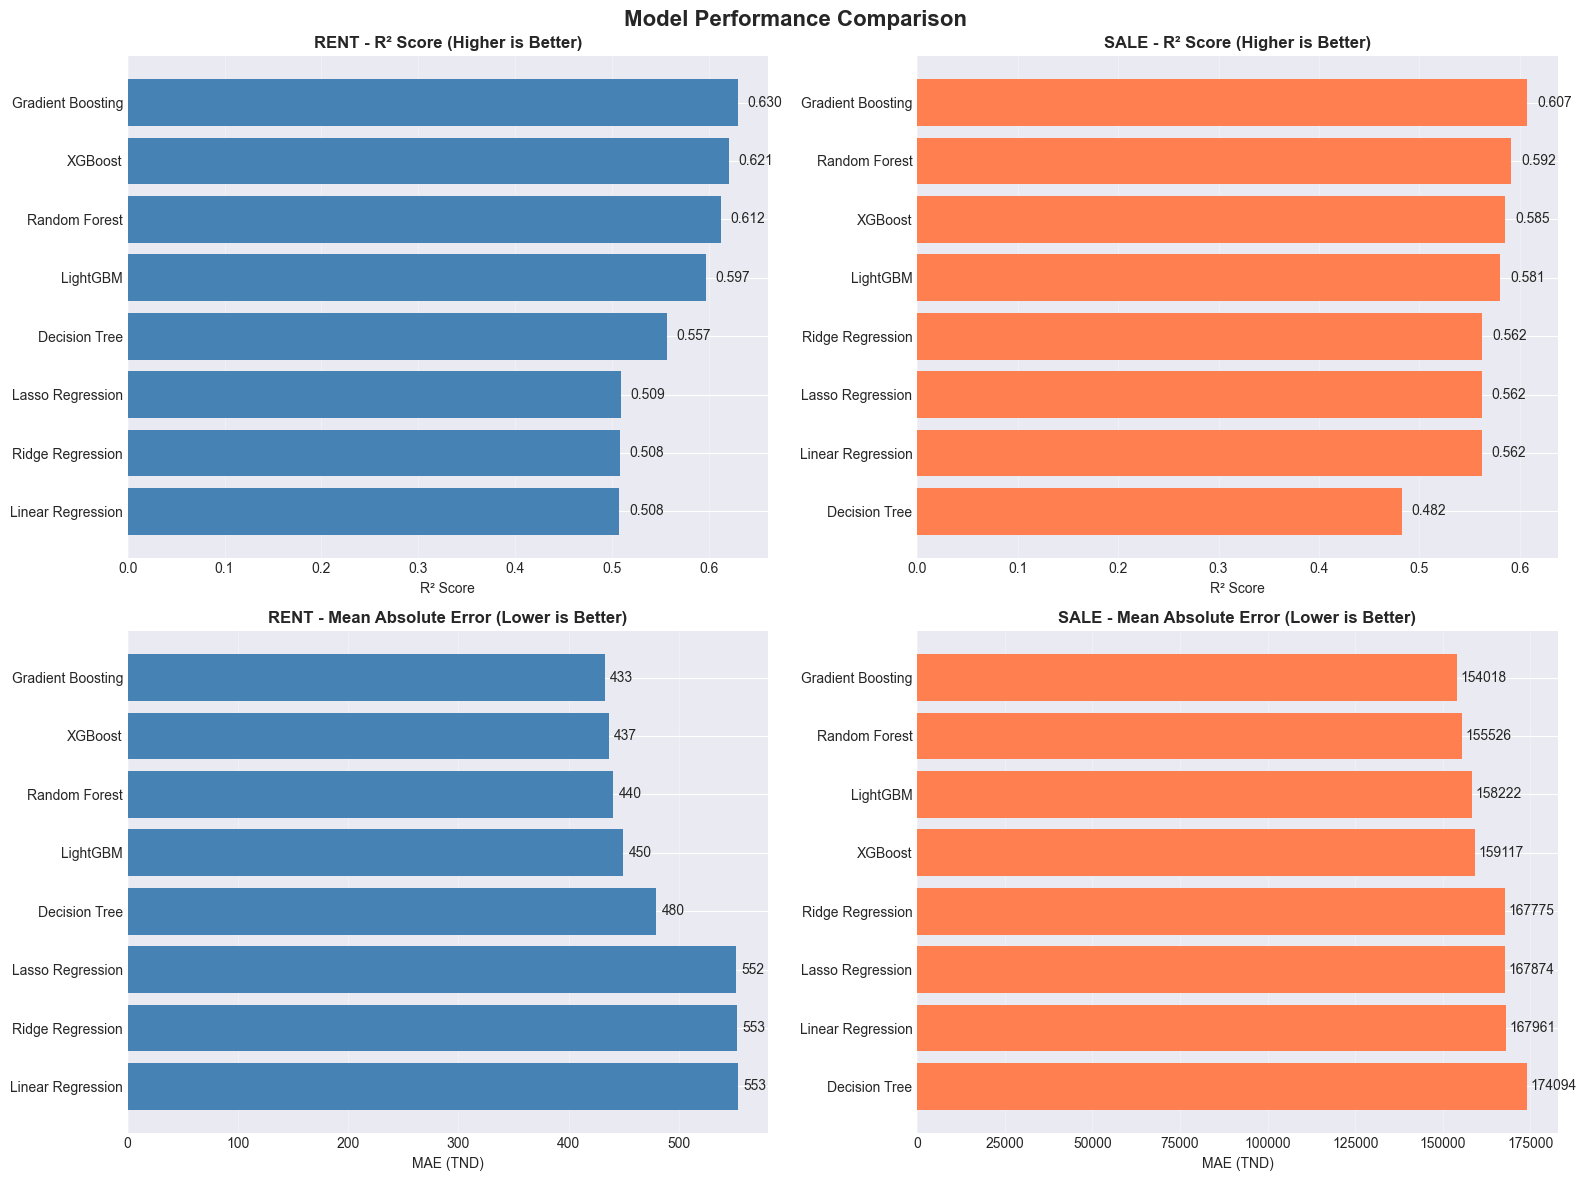

✅ Comparison plot saved!


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# RENT - R² Score
ax1 = axes[0, 0]
rent_r2_sorted = rent_results_df.sort_values('test_r2', ascending=True)
ax1.barh(rent_r2_sorted['model'], rent_r2_sorted['test_r2'], color='steelblue')
ax1.set_xlabel('R² Score')
ax1.set_title('RENT - R² Score (Higher is Better)', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(rent_r2_sorted['test_r2']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center')

# SALE - R² Score
ax2 = axes[0, 1]
sale_r2_sorted = sale_results_df.sort_values('test_r2', ascending=True)
ax2.barh(sale_r2_sorted['model'], sale_r2_sorted['test_r2'], color='coral')
ax2.set_xlabel('R² Score')
ax2.set_title('SALE - R² Score (Higher is Better)', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(sale_r2_sorted['test_r2']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center')

# RENT - MAE
ax3 = axes[1, 0]
rent_mae_sorted = rent_results_df.sort_values('test_mae', ascending=False)
ax3.barh(rent_mae_sorted['model'], rent_mae_sorted['test_mae'], color='steelblue')
ax3.set_xlabel('MAE (TND)')
ax3.set_title('RENT - Mean Absolute Error (Lower is Better)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(rent_mae_sorted['test_mae']):
    ax3.text(v + 5, i, f'{v:.0f}', va='center')

# SALE - MAE
ax4 = axes[1, 1]
sale_mae_sorted = sale_results_df.sort_values('test_mae', ascending=False)
ax4.barh(sale_mae_sorted['model'], sale_mae_sorted['test_mae'], color='coral')
ax4.set_xlabel('MAE (TND)')
ax4.set_title('SALE - Mean Absolute Error (Lower is Better)', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
for i, v in enumerate(sale_mae_sorted['test_mae']):
    ax4.text(v + 1000, i, f'{v:.0f}', va='center')

plt.tight_layout()
plt.show()

print("✅ Comparison plot saved!")

## 8. Visualize Predictions vs Actual (Best Models)

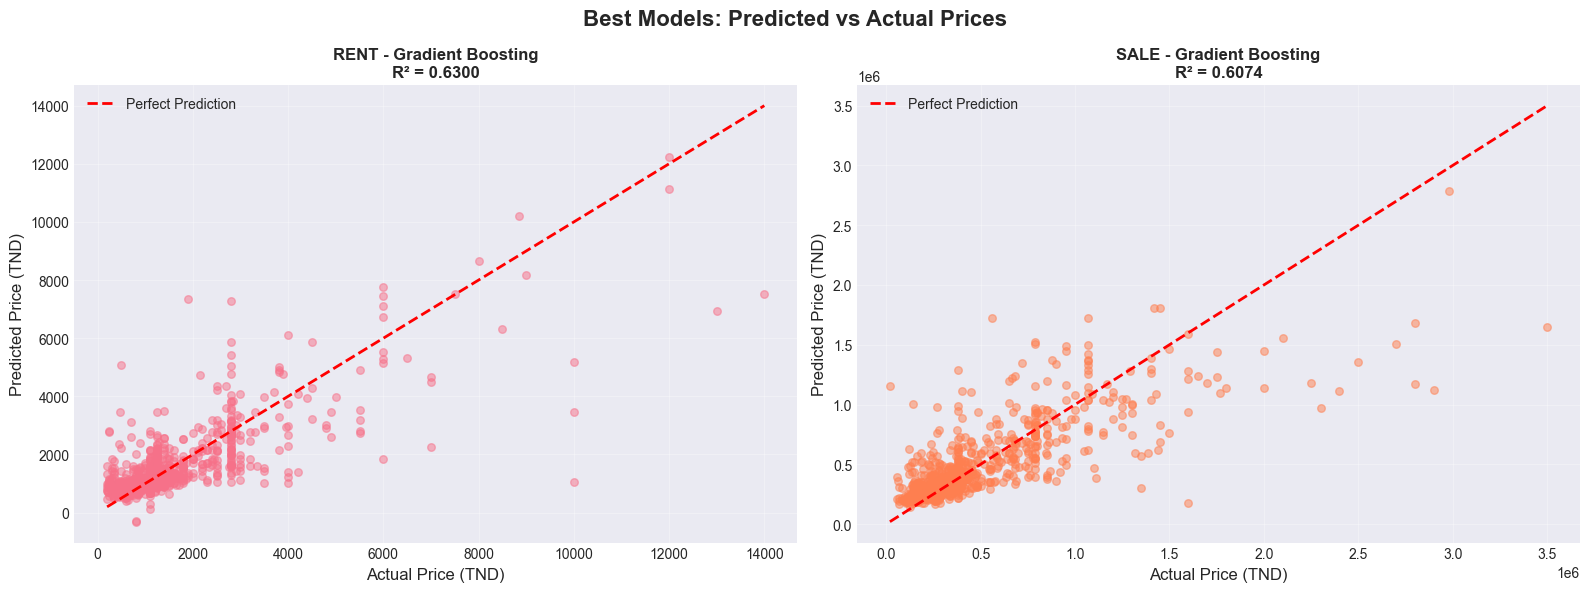

✅ Predictions plot saved!


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Best Models: Predicted vs Actual Prices', fontsize=16, fontweight='bold')

# RENT - Best Model
ax1 = axes[0]
y_rent_pred_best = rent_predictions[best_rent_model]
ax1.scatter(y_rent_test, y_rent_pred_best, alpha=0.5, s=30)
ax1.plot([y_rent_test.min(), y_rent_test.max()], 
         [y_rent_test.min(), y_rent_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (TND)', fontsize=12)
ax1.set_ylabel('Predicted Price (TND)', fontsize=12)
ax1.set_title(f'RENT - {best_rent_model}\nR² = {rent_results_df["test_r2"].max():.4f}', 
              fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# SALE - Best Model
ax2 = axes[1]
y_sale_pred_best = sale_predictions[best_sale_model]
ax2.scatter(y_sale_test, y_sale_pred_best, alpha=0.5, s=30, color='coral')
ax2.plot([y_sale_test.min(), y_sale_test.max()], 
         [y_sale_test.min(), y_sale_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price (TND)', fontsize=12)
ax2.set_ylabel('Predicted Price (TND)', fontsize=12)
ax2.set_title(f'SALE - {best_sale_model}\nR² = {sale_results_df["test_r2"].max():.4f}', 
              fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Predictions plot saved!")

## 9. Residual Analysis (Best Models)

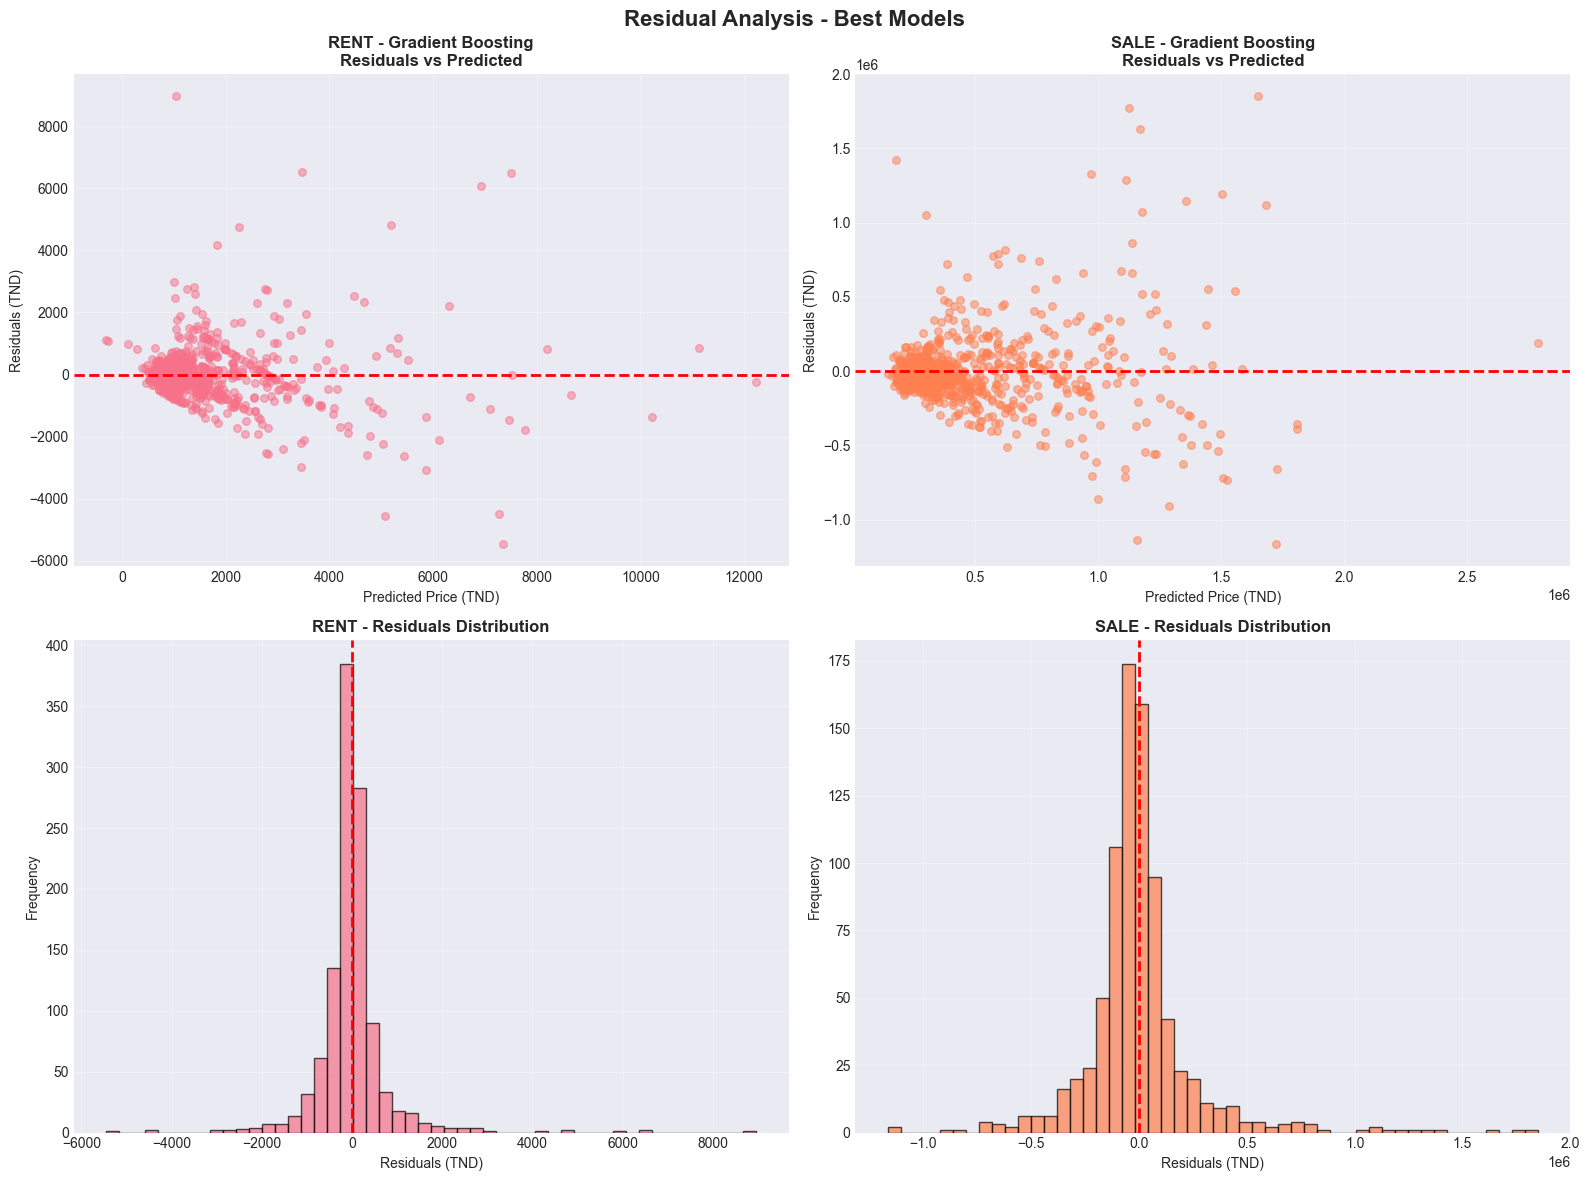

✅ Residuals analysis plot saved!


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Residual Analysis - Best Models', fontsize=16, fontweight='bold')

# RENT - Residuals vs Predicted
ax1 = axes[0, 0]
rent_residuals = y_rent_test - y_rent_pred_best
ax1.scatter(y_rent_pred_best, rent_residuals, alpha=0.5, s=30)
ax1.axhline(y=0, color='r', linestyle='--', lw=2)
ax1.set_xlabel('Predicted Price (TND)')
ax1.set_ylabel('Residuals (TND)')
ax1.set_title(f'RENT - {best_rent_model}\nResiduals vs Predicted', fontweight='bold')
ax1.grid(alpha=0.3)

# SALE - Residuals vs Predicted
ax2 = axes[0, 1]
sale_residuals = y_sale_test - y_sale_pred_best
ax2.scatter(y_sale_pred_best, sale_residuals, alpha=0.5, s=30, color='coral')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price (TND)')
ax2.set_ylabel('Residuals (TND)')
ax2.set_title(f'SALE - {best_sale_model}\nResiduals vs Predicted', fontweight='bold')
ax2.grid(alpha=0.3)

# RENT - Residuals Distribution
ax3 = axes[1, 0]
ax3.hist(rent_residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residuals (TND)')
ax3.set_ylabel('Frequency')
ax3.set_title('RENT - Residuals Distribution', fontweight='bold')
ax3.grid(alpha=0.3)

# SALE - Residuals Distribution
ax4 = axes[1, 1]
ax4.hist(sale_residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(x=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Residuals (TND)')
ax4.set_ylabel('Frequency')
ax4.set_title('SALE - Residuals Distribution', fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Residuals analysis plot saved!")

## 10. Check for Overfitting (Train vs Test Performance)

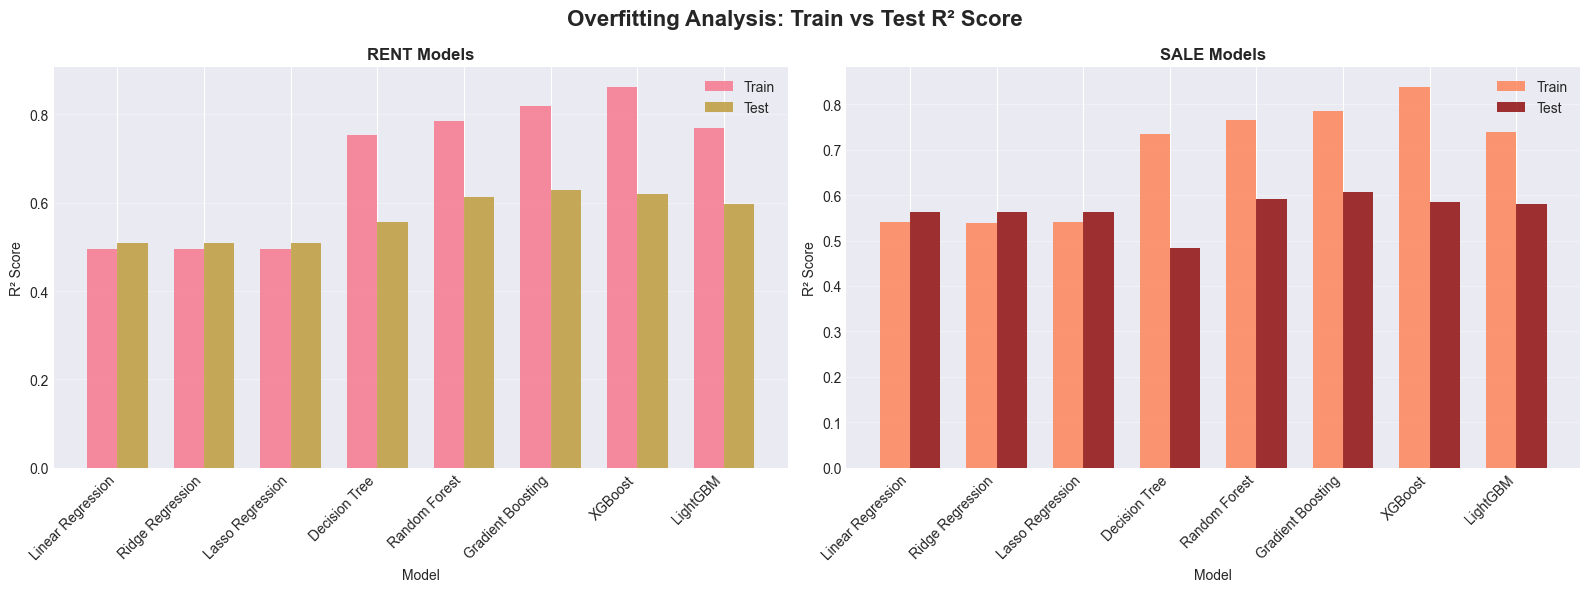


OVERFITTING ANALYSIS (Train R² - Test R²)

RENT:
            model  train_r2  test_r2  overfitting_gap
Linear Regression  0.496260 0.507909        -0.011648
 Ridge Regression  0.496223 0.508378        -0.012155
 Lasso Regression  0.495136 0.509378        -0.014242
    Decision Tree  0.753276 0.556936         0.196340
    Random Forest  0.784224 0.612437         0.171787
Gradient Boosting  0.819745 0.629965         0.189780
          XGBoost  0.863013 0.620676         0.242337
         LightGBM  0.769558 0.597023         0.172534

SALE:
            model  train_r2  test_r2  overfitting_gap
Linear Regression  0.539665 0.561906        -0.022241
 Ridge Regression  0.539445 0.562434        -0.022989
 Lasso Regression  0.539664 0.562017        -0.022352
    Decision Tree  0.733742 0.482449         0.251293
    Random Forest  0.765054 0.591677         0.173377
Gradient Boosting  0.784989 0.607351         0.177638
          XGBoost  0.838635 0.585169         0.253466
         LightGBM  0.7385

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Overfitting Analysis: Train vs Test R² Score', fontsize=16, fontweight='bold')

# RENT - Train vs Test R²
ax1 = axes[0]
x = np.arange(len(rent_results_df))
width = 0.35
ax1.bar(x - width/2, rent_results_df['train_r2'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, rent_results_df['test_r2'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('RENT Models', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(rent_results_df['model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# SALE - Train vs Test R²
ax2 = axes[1]
x = np.arange(len(sale_results_df))
ax2.bar(x - width/2, sale_results_df['train_r2'], width, label='Train', alpha=0.8, color='coral')
ax2.bar(x + width/2, sale_results_df['test_r2'], width, label='Test', alpha=0.8, color='darkred')
ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('SALE Models', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sale_results_df['model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate overfitting gap
print("\n" + "=" * 100)
print("OVERFITTING ANALYSIS (Train R² - Test R²)")
print("=" * 100)

print("\nRENT:")
rent_results_df['overfitting_gap'] = rent_results_df['train_r2'] - rent_results_df['test_r2']
print(rent_results_df[['model', 'train_r2', 'test_r2', 'overfitting_gap']].to_string(index=False))

print("\nSALE:")
sale_results_df['overfitting_gap'] = sale_results_df['train_r2'] - sale_results_df['test_r2']
print(sale_results_df[['model', 'train_r2', 'test_r2', 'overfitting_gap']].to_string(index=False))

print("\n✅ Overfitting analysis complete!")

## 11. Save Best Models

In [ ]:
import os

# Create models directory
MODELS_DIR = "/mnt/user-data/outputs/models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Save best RENT model
joblib.dump(
    rent_models_trained[best_rent_model],
    f"{MODELS_DIR}/best_rent_model.joblib"
)

# Save best SALE model
joblib.dump(
    sale_models_trained[best_sale_model],
    f"{MODELS_DIR}/best_sale_model.joblib"
)

# Save all models (optional)
for name, model in rent_models_trained.items():
    safe_name = name.replace(' ', '_').lower()
    joblib.dump(model, f"{MODELS_DIR}/rent_{safe_name}.joblib")

for name, model in sale_models_trained.items():
    safe_name = name.replace(' ', '_').lower()
    joblib.dump(model, f"{MODELS_DIR}/sale_{safe_name}.joblib")

print("✅ All models saved!")
print(f"\nBest models:")
print(f"  RENT: {MODELS_DIR}/best_rent_model.joblib ({best_rent_model})")
print(f"  SALE: {MODELS_DIR}/best_sale_model.joblib ({best_sale_model})")

## 12. Save Results to CSV

In [ ]:
# Save detailed results
rent_results_df.to_csv('/mnt/user-data/outputs/rent_models_results.csv', index=False)
sale_results_df.to_csv('/mnt/user-data/outputs/sale_models_results.csv', index=False)

# Create summary report
summary = {
    'Transaction Type': ['RENT', 'SALE'],
    'Best Model': [best_rent_model, best_sale_model],
    'Best R²': [
        rent_results_df['test_r2'].max(),
        sale_results_df['test_r2'].max()
    ],
    'Best MAE': [
        rent_results_df.loc[rent_results_df['test_r2'].idxmax(), 'test_mae'],
        sale_results_df.loc[sale_results_df['test_r2'].idxmax(), 'test_mae']
    ],
    'Best RMSE': [
        rent_results_df.loc[rent_results_df['test_r2'].idxmax(), 'test_rmse'],
        sale_results_df.loc[sale_results_df['test_r2'].idxmax(), 'test_rmse']
    ],
    'Best MAPE': [
        rent_results_df.loc[rent_results_df['test_r2'].idxmax(), 'test_mape'],
        sale_results_df.loc[sale_results_df['test_r2'].idxmax(), 'test_mape']
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('/mnt/user-data/outputs/models_summary.csv', index=False)

print("✅ Results saved to CSV!")
print("\n" + "=" * 100)
print("FINAL SUMMARY")
print("=" * 100)
print(summary_df.to_string(index=False))

## 13. Conclusions and Next Steps

### Key Findings:
- Best performing models identified for both rent and sale predictions
- Separate models significantly outperform single combined model
- Overfitting analysis helps identify most generalizable models

### Next Steps:
1. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV on best models
2. **Feature Engineering**: Try additional features or interactions
3. **Ensemble Methods**: Combine multiple models for better predictions
4. **Cross-Validation**: Perform k-fold CV for more robust evaluation
5. **Error Analysis**: Deep dive into worst predictions to understand failure modes
6. **Deployment**: Create API for real-time predictions

### Model Selection Criteria:
- **R² Score**: How much variance is explained (higher is better)
- **MAE**: Average prediction error in TND (lower is better)
- **RMSE**: Penalizes large errors more than MAE (lower is better)
- **MAPE**: Error as percentage of actual price (lower is better)
- **Overfitting Gap**: Difference between train and test R² (lower is better)

Choose the model that best balances accuracy, generalization, and interpretability for your use case!